# Fluxcourse SIF section (2)

## Introduction
In this section, we will learn how to process SIF data from multiple satellite platforms. At the end of this section, we will compare satellite SIF data with GPP estimation from a few FLUXNET towers. We will go through the following sections:

* The start: how to read SIF data?
* Post-processing: how to create scientifically useful datasets and visualize them?
* Do what we see from the satellite agree with what we see from the ground (i.e. FLUXNET or Ameriflux)?

## Logistics
We use Jupyter Notebook for this practice. Remember to install the packages using "conda install [package-name]" in your command line. Before the course, remember to update your conda (if you use anaconda) by "conda update conda".
You will need the following packages:

* matplotlib
* numpy
* scipy
* h5py
* netCDF4
* glob
* traceback

A large portion of this code is from **Christian Frankenberg and Philipp Koehler**. L2_tools.py provides the tools to use TROPOMI and OCO-2 L2 data. You will need to have the following files under the same folder of this code:

* L2_tools.py: read SIF data; calculate running mean
* spectral_shape.dat: the spectral shape you created from the previous section

Another useful tool to read netCDF file is Panoply. It is a free software from NASA. Download it from here: https://www.giss.nasa.gov/tools/panoply/

---------------

The first step, instead of writing python code, is to read these satellite data with Panoply. Panoply provides a graphical-user-interface (GUI) that allows you to check the variables available and visualize them. 

**Let's load a few packages**

In [1]:
# Remember to install these packages
import matplotlib.pyplot as plt
import numpy as np
import scipy
import h5py
# nicer figures using ggg plot style.
plt.style.use('ggplot')

from IPython.core.display import HTML
from IPython.display import clear_output
from IPython.core.pylabtools import figsize

# Register the converters to avoid further warnings
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# hide all warnings
import warnings
warnings.filterwarnings('ignore')

**Remember to add L2_tool.py to the same folder**

In [2]:
# This file L2_tools.py is in the same folder here and will provide easy access to TROPOMI and OCO-2 L2 data 
from L2_tools import *

**Add the paths for OCO2 and TROPOMI**
Here we use ungridded datasets, meaning individual soundings of satellite scans. We will select a geographical region, and average all the data points in that region.

In [7]:
# Please adapt to your local directories after having mirrored our ftp data (and extracted the ungridded TROPOMI files):
path_tropomi = '/Users/xiyang/Desktop/FluxCourse/TROPOMI/nc_ungridded/'
path_oco2 = '/Users/xiyang/Desktop/FluxCourse/OCO2/sif_lite_B8100/'

# This is still cumbersome, the units are part of the netCDF4 files but I (CF) hardcode them for now:
t_unit_oco2    = "seconds since 1993-01-01 00:00:00"
t_unit_tropomi = "seconds since 1970-01-01 00:00:00"
t_cal = u"gregorian"

**What will something that does not fluoresce look like in the satellite SIF images?**

In [8]:
# Let us read in some OCO-2 and TROPOMI data over a non-fluorescing region in the Sahara
# Define region boundaries for a part of the Sahara:
latMin = 20
latMax = 23
lonMin = 5
lonMax = 8

**Now, depending on how much data you have, the following two functions may take some time**

The syntax for reading in data is as follows: data = L2(path_to_data, dictionary,latMin, latMax, lonMin, lonMax ) -- the last four input to the function define the rectangle of the region of interest

Find some examples for the dictionary below (these can be adapted to read in GOME-2 data). The format describes the "key" as how you want to name the variable in your returned class and the "item" as the variable name of the HDF5 file.

In [9]:
oco2_sahara = L2(path_oco2+'2018/0[45678]/*.nc4', dict_oco2,latMin, latMax, lonMin, lonMax )

In [10]:
# TROPOMI will take a bit more time, be patient!
tropomi_sahara = L2(path_tropomi+'*2018-0[45678]*.nc', dict_tropomi,latMin, latMax, lonMin, lonMax )

It basically goes through the HDF5 files and uses a dictionary to decide which variables to read in. Then, it just concatenates all the data into a larger set and stores everything in a class (just think of it like a structure for now)

**You can take a look at L2_tools.py, and you will find the following code, which are the variables in OCO2 or TROPOMI files**

In [11]:
dict_oco2

{'lat': 'latitude',
 'lon': 'longitude',
 'sza': 'solar_zenith_angle',
 'vza': 'sensor_zenith_angle',
 'saa': 'solar_azimuth_angle',
 'vaa': 'sensor_azimuth_angle',
 'biome': 'IGBP_index',
 'mode': 'measurement_mode',
 'sif_757': 'SIF_757nm',
 'sif_771': 'SIF_771nm',
 'sif_757_sigma': 'SIF_757nm_uncert',
 'sif_771_sigma': 'SIF_771nm_uncert',
 'dcCorr': 'daily_correction_factor',
 'time': 'time'}

In [12]:
dict_tropomi

{'lat': 'lat',
 'lon': 'lon',
 'sza': 'sza',
 'vza': 'vza',
 'phaseAngle': 'phase_angle',
 'sif': 'sif',
 'sif_sigma': 'sif_err',
 'dcCorr': 'daily_correction_factor',
 'time': 'TIME'}

**Now we have the data loaded, let's plot some figures**

In [13]:
# First convert oco2 time units to a python time (this is a clunky step right now, need to automate later!)
oco2_sahara.time_python    = convert_time(oco2_sahara.time, t_unit_oco2, t_cal)
tropomi_sahara.time_python = convert_time(tropomi_sahara.time, t_unit_tropomi, t_cal)

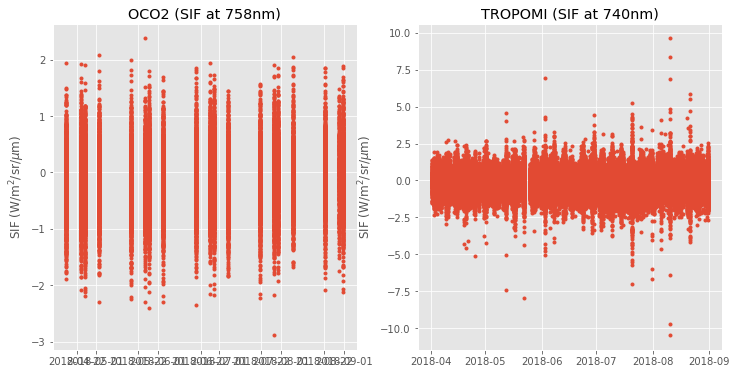

In [14]:
# now lets plot a timeseries
figsize(12,6)
plt.subplot(1,2,1)
plt.plot(oco2_sahara.time_python, oco2_sahara.sif_757,'.')
plt.ylabel('SIF (W/m$^2$/sr/$\mu$m)')
plt.title('OCO2 (SIF at 758nm)')
plt.subplot(1,2,2)
plt.plot(tropomi_sahara.time_python, tropomi_sahara.sif,'.')
plt.ylabel('SIF (W/m$^2$/sr/$\mu$m)')
plt.title('TROPOMI (SIF at 740nm)')
plt.show()

**Hmmm, wait a minute! Does the result make sense?**

We looked at the Sahara and SIF should be around 0. The data looks very noisy, can we make use of that? Should we just exclude all the negative data?

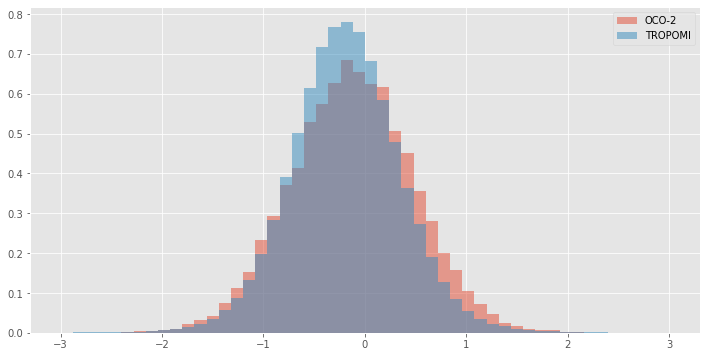

In [15]:
# let us look at a histogram
plt.hist(oco2_sahara.sif_757, 50,range=(-3,3), density=True, alpha=0.5, label='OCO-2')
plt.hist(tropomi_sahara.sif,  50,range=(-3,3), density=True, alpha=0.5, label='TROPOMI')
plt.legend(loc=0)
plt.show()

In [16]:
print('Standard deviation of measured OCO-2 SIF data in Sahara ' + str(np.std(oco2_sahara.sif_757)) )
print('Expected standard deviation based on posteriori error ' + str(np.mean(oco2_sahara.sif_757_sigma)) )

Standard deviation of measured OCO-2 SIF data in Sahara 0.60388136
Expected standard deviation based on posteriori error 0.50652856


In [17]:
print('Mean if we exclude negative data ' + str(np.mean(oco2_sahara.sif_757[oco2_sahara.sif_757>=0])))
print('True mean ' + str(np.mean(oco2_sahara.sif_757)))

Mean if we exclude negative data 0.4354612
True mean -0.12516174


You can see 2 things here: a) removing negative values is dangerous. If the true value is 0 and we have measurement noise, negative retrievals are not unphysical if they are within the posterior noise estimate; b) we sometimes have averages that are below  (e.g. -0.12 here). This can happen and really depends on the posterior bias correction. 

Christian and Philipp are still working on this but removing small biases on the order of 0.1 is really hard.

-----

**Let's take a look at some vegetated surface**

What would you expect to see? Say from April 2018 to August 2018.

In [18]:
# Define region boundaries (roughly Iowa)
latMin_cb = 40
latMax_cb = 43
lonMin_cb = -96
lonMax_cb = -91

In [19]:
oco2_iowa = L2(path_oco2+'2018/0[45678]/*.nc4', dict_oco2,latMin_cb, latMax_cb, lonMin_cb, lonMax_cb )

In [20]:
tropomi_iowa = L2(path_tropomi+'*2018-0[45678]*.nc', dict_tropomi,latMin_cb, latMax_cb, lonMin_cb, lonMax_cb )

In [21]:
# Again, convert tedious times in the files to something you can work with in python
oco2_iowa.time_python    = convert_time(oco2_iowa.time, t_unit_oco2, t_cal)
tropomi_iowa.time_python = convert_time(tropomi_iowa.time, t_unit_tropomi, t_cal)

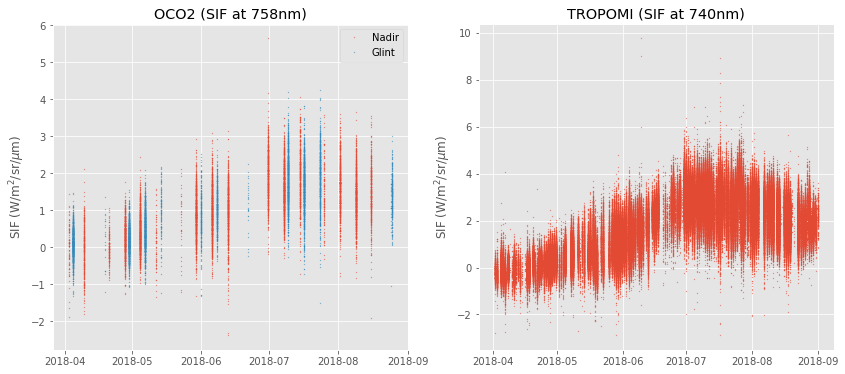

In [22]:
# now lets plot a timeseries
figsize(14,6)
plt.subplot(1,2,1)
nadir = np.where(oco2_iowa.mode==0)[0]
glint = np.where(oco2_iowa.mode==1)[0]
plt.plot(oco2_iowa.time_python[nadir], oco2_iowa.sif_757[nadir],'.',markersize=0.5, label='Nadir')
plt.plot(oco2_iowa.time_python[glint], oco2_iowa.sif_757[glint],'.',markersize=0.5, label='Glint')
plt.ylabel('SIF (W/m$^2$/sr/$\mu$m)')
plt.title('OCO2 (SIF at 758nm)')
plt.legend(loc=0)
plt.subplot(1,2,2)
plt.plot(tropomi_iowa.time_python, tropomi_iowa.sif,'.',markersize=0.5)
plt.ylabel('SIF (W/m$^2$/sr/$\mu$m)')
plt.title('TROPOMI (SIF at 740nm)')
plt.show()

**What do you see here?**
A few things: 1) Both OCO2 and TROPOMI show a similar seasonal pattern; 2) Quite large variations each day. 3) Glint and Nadir view produce similar values.

---
## Let us compute timeseries from OCO-2 and TROPOMI data
You can see that individual data are too noisy to work with, thus we have to average. Looking at Iowa, we see that we have more than enough data for averaging. Now we can define a temporal resolution and create a running mean to drive down the noise (which should scale with $1/\sqrt{n}$):

In [23]:
# Let us define some averaging interval, get data every 3 days and create a running mean of +/- 3 days:
from datetime import datetime
# Define data range to smooth on (every 3 days)
dates = np.arange('2018-04', '2018-08', dtype='datetime64[3D]').astype(datetime)

In [24]:
# We used dates with a 3 day time-step and now use a +/- 3 day filter for the running mean:
iowa_timeseries_oco2 =    sif_rMean(oco2_iowa.time_python, oco2_iowa.sif_757,dates, 3 )
iowa_timeseries_tropomi = sif_rMean(tropomi_iowa.time_python, tropomi_iowa.sif,dates, 3 )

Here you can play with the time-steps to create something like a 30-day running mean.

Text(0.5, 1.0, 'Iowa Timeseries, +/-3 day running mean')

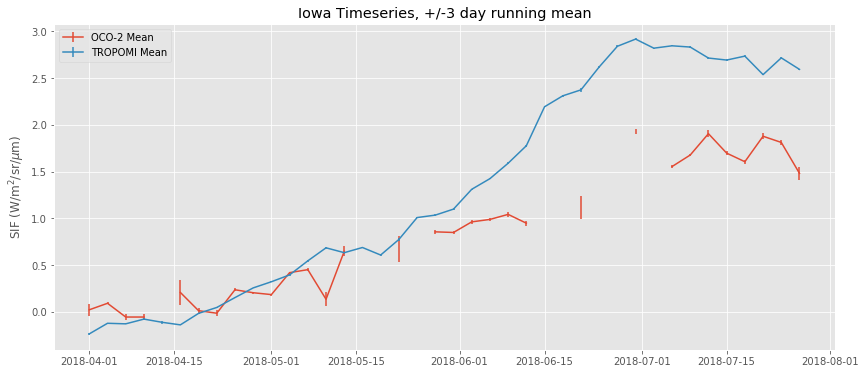

In [25]:
# Conversion factor from 758nm to 740nm is roughly 1.55
cf = 1.55
plt.errorbar(dates, iowa_timeseries_oco2.mean,yerr=iowa_timeseries_oco2.standard_error, label='OCO-2 Mean')
plt.errorbar(dates, iowa_timeseries_tropomi.mean,yerr=iowa_timeseries_tropomi.standard_error,  label='TROPOMI Mean')
plt.ylabel('SIF (W/m$^2$/sr/$\mu$m)')
plt.legend(loc=0)
plt.title('Iowa Timeseries, +/-3 day running mean')

---
We see that the time-series agree reasonably well but that there is an offset (or scaling factor) as we define SIF at different wavelength. Why? (Hint: think about the leaf SIF measurements you made).

I have loaded some SIF spectra based on SCOPE and leaf-level measurements using L2_tools.

* shape_scope is the SIF spectra from SCOPE
* shape_walz is the SIF spectra from Magney et al. (2017) NPH

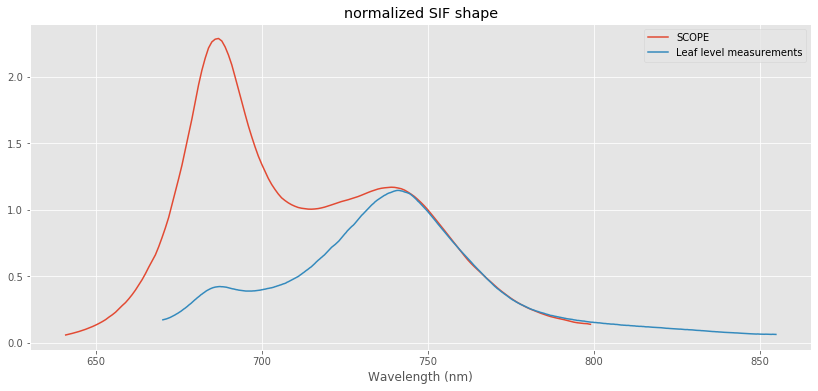

In [26]:
plt.plot(shape_scope[:,0], shape_scope[:,1], label='SCOPE')
plt.plot(shape_walz[:,0], shape_walz[:,1]*12, label='Leaf level measurements')
plt.title('normalized SIF shape')
plt.xlabel('Wavelength (nm)')
plt.legend()
plt.show()

We can see that SIF changes quite a bit with wavelength but that the overall shape $>$740nm us pretty consistent between our leaf level measurements and the SCOPE model. The shorter wavelength is more affected by chlorophyll re-absorption, which can dramatically change the shape. Read Troy's paper here: 

Magney, T.S., Frankenberg, C., Fisher, J.B., Sun, Y., North, G.B., Davis, T.S., Kornfeld, A. and Siebke, K., 2017. [Connecting active to passive fluorescence with photosynthesis: A method for evaluating remote sensing measurements of Chl fluorescence.](https://doi.org/10.1111/nph.14662) New Phytologist, 215(4), pp.1594-1608.

### How to correct for it?
We provide a simple routine to convert the scaling factor needed to convert data from wavelength X to Y: Let's say we want to convert OCO-2 data from 758nm to the TROPOMI grid of 740nm, we get the following scaling factor:

In [27]:
print('Factor from leaf level ',convertWL(758,740,shape_walz))
fac = convertWL(758,740,shape_walz)

Factor from leaf level  1.5259125192247691


Now we can use the factor to better match the 2 time-series:

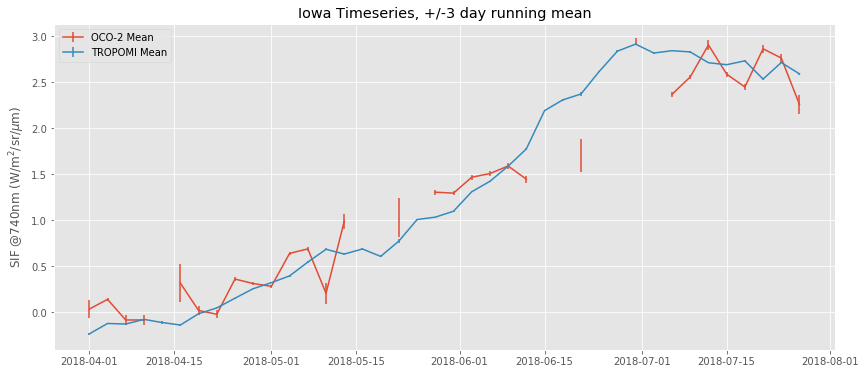

In [28]:
# Conversion factor from 758nm to 740nm is roughly 1.55 (we can provide shapes if needed)
plt.errorbar(dates, iowa_timeseries_oco2.mean*fac,yerr=iowa_timeseries_oco2.standard_error*fac, label='OCO-2 Mean')
plt.errorbar(dates, iowa_timeseries_tropomi.mean,yerr=iowa_timeseries_tropomi.standard_error,  label='TROPOMI Mean')
plt.ylabel('SIF @740nm (W/m$^2$/sr/$\mu$m)')
plt.legend(loc=0)
plt.title('Iowa Timeseries, +/-3 day running mean')
plt.show()

## Correction for overpass time and length of day:
Another crucial impact is due to changes in the overpass time and how to relate the instantaenous SIF to a daily average. Our first simple approximations are just based on calculations of the ratio of a daily average PAR vs instantaenous PAR (assuming cloud free conditions). To first order, this should bring different instruments into better alignment. We provide this conversion factor for all instruments. For TROPOMI and OCO-2, it is not a huge factor as the overpass time is similar (note though the the factor changes between the eastern and western part of the TROPOMI swath as the local time changes quite a bit):

In [ ]:
# Let's calculate the SIF timeseries including the length of day correction:
# Do the same for the length of day correction
iowa_timeseries_tropomiDC = sif_rMean(tropomi_iowa.time_python, tropomi_iowa.sif*tropomi_iowa.dcCorr,dates, 3 )
iowa_timeseries_oco2DC =    sif_rMean(oco2_iowa.time_python, oco2_iowa.sif_757*oco2_iowa.dcCorr,dates, 3 )

In [ ]:
plt.plot(dates, iowa_timeseries_oco2DC.mean*fac, label='OCO-2 LOD corrected')
plt.plot(dates, iowa_timeseries_tropomiDC.mean, label='TROPOMI LOD corrected')
plt.legend()
plt.ylabel('$\overline{SIF}$ @740nm (W/m$^2$/sr/$\mu$m)')
plt.title('Length of Day correction impact')
plt.show()

**Compare the temporal trend and the magnitude of SIF values you get, what do you see? Why?**

### Now let's do it for another site. How about do it yourself? Let's choose Tonzi.


In [29]:
# First, let's define the Region of Interest
latMin_cb = 38.4
latMax_cb = 38.5
lonMin_cb = -121
lonMax_cb = -120.9

# Read OCO2 and TROPOMI data
#oco2_tonzi = L2(path_oco2+'2018/0[45678]/*.nc4', dict_oco2,latMin_cb, latMax_cb, lonMin_cb, lonMax_cb )
tropomi_tonzi = L2(path_tropomi+'*.nc', dict_tropomi,latMin_cb, latMax_cb, lonMin_cb, lonMax_cb )

# Convert time
#oco2_tonzi.time_python    = convert_time(oco2_tonzi.time, t_unit_oco2, t_cal)
tropomi_tonzi.time_python = convert_time(tropomi_tonzi.time, t_unit_tropomi, t_cal)

# Just do the averaging
from datetime import datetime
# Define data range to smooth on (every 3 days)
dates = np.arange('2018-04', '2019-04', dtype='datetime64[3D]').astype(datetime)

# Let's calculate the SIF timeseries including the length of day correction:
# Do the same for the length of day correction
tonzi_timeseries_tropomiDC = sif_rMean(tropomi_tonzi.time_python, tropomi_tonzi.sif*tropomi_tonzi.dcCorr,dates, 3 )
#tonzi_timeseries_oco2DC =    sif_rMean(oco2_tonzi.time_python, oco2_tonzi.sif_757*oco2_tonzi.dcCorr,dates, 3 )

# Here we will use the data you create from leaf-level measurements
fac = convertWL(758,740,shape_walz)

### How good it is compared with EC data?


In [30]:
import pandas as pd

path      = '/Users/xiyang/Documents/GitHub/FluxCourse/Tonzi_DailyGEE2.csv'
df        = pd.read_csv(path)
t_ec_unit = 'days since 1900-01-01 00:00:00'
ecdates   = num2date(df['DOY'],units = t_ec_unit,calendar = t_cal)

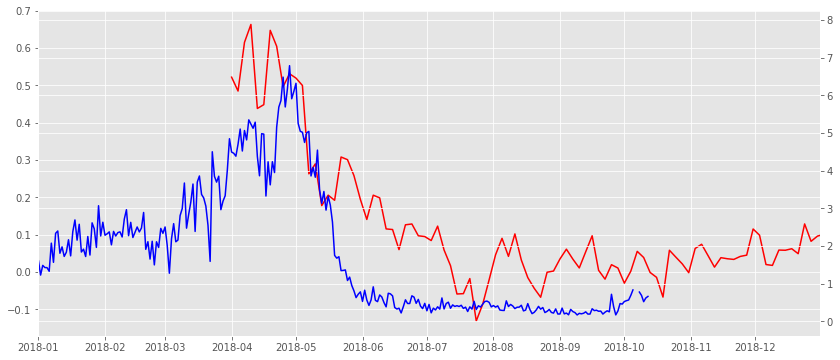

In [31]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax1.plot(dates, tonzi_timeseries_oco2DC.mean*fac, label='OCO-2 LOD corrected')
ax1.plot(dates, tonzi_timeseries_tropomiDC.mean,'r-', label='TROPOMI LOD corrected')
ax1.set_xlim([datetime(2018,1,1,0,0),datetime(2018,12,31,0,0)])

ax2 = ax1.twinx()
ax2.plot(ecdates, -df['GEE'],'b-')
ax2.set_xlim([datetime(2018,1,1,0,0),datetime(2018,12,31,0,0)])
plt.show()